In [1]:
! nvidia-smi

Sat Dec  9 10:03:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ResNet网络介绍

**网络的亮点：**

**（1）超深的网络结构，突破1000层（解决了之前模型中因为结构深导致的梯度消失或者爆炸问题，以及退化问题**

**（2）提出了residual残差模块**

**（3）使用Batch Normalization加速训练（丢弃dropout）**


### 梯度与梯度消失/爆炸

**什么是梯度：**

在深度学习神经网络中，梯度是指目标函数（损失函数）对于网络参数的偏导数。

它表示了目标函数在参数空间中的变化率，指示了在给定参数下目标函数变化最快的方向。

在神经网络的训练过程中，我们通过反向传播算法计算梯度，然后使用梯度下降或其变种方法来更新网络的参数，以最小化目标函数。

梯度告诉我们当前参数值相对于目标函数的斜率方向，使我们能够朝着降低目标函数的方向进行参数调整。

具体而言，对于每个参数（权重和偏置），我们计算其对应的偏导数，这样我们就得到了梯度向量。

梯度向量中的每个元素表示了相应参数对目标函数的影响程度，正负号表示了参数调整的方向。

通过在每次迭代中计算和应用梯度，我们可以逐步调整网络参数，使得目标函数逐渐减小，从而实现网络的训练和优化。

梯度在深度学习中扮演着重要的角色，它提供了反馈信号，指导网络参数的更新，使得网络能够逐渐逼近最优解。

**什么是梯度消失/爆炸**

梯度消失和梯度爆炸是深度学习神经网络中常见的问题，涉及到梯度在反向传播过程中的衰减或增长。

（1）梯度消失（Gradient Vanishing）：
梯度消失指的是在神经网络的反向传播过程中，梯度逐渐变小并趋近于零。
当网络的层数增多时，梯度在每一层中都会经历乘法操作，导致梯度值逐渐减小。（当每一层梯度都小于1）
当梯度变得非常小，甚至接近于零时，权重更新的信息变得非常微弱，导致网络无法学习有效的表示，从而影响了网络的性能和收敛速度。

（2）梯度爆炸（Gradient Explosion）：
梯度爆炸是指在反向传播过程中，梯度逐渐增大并迅速变得非常大。
当网络的层数增多时，梯度在每一层中都会经历乘法操作，导致梯度值逐渐增大。（当每一层梯度都大于1）
如果梯度值变得非常大，权重更新的步幅也会变得非常大，导致权重值发生剧烈的变化，网络可能无法收敛，甚至发散。

**梯度消失/爆炸的解决办法**

梯度消失和梯度爆炸通常发生在深度神经网络中，
特别是使用某些激活函数（如sigmoid）和深层网络结构（如循环神经网络）时更容易出现这些问题。

解决梯度消失和梯度爆炸问题的常见方法如下：

**(1)梯度消失的解决办法：**

<1>使用合适的激活函数：将原本使用sigmoid函数的激活函数替换为ReLU（Rectified Linear Unit）或其变种，
   如Leaky ReLU、Parametric ReLU等。
   这些激活函数在负值区域具有较大的梯度，可以缓解梯度消失问题。

<2>使用合适的参数初始化方法，如Xavier初始化或He初始化，
   可以确保参数初始值不过大或过小，减少梯度在网络中传播时的衰减。

<3>使用残差连接（Residual connections）：在网络的某些层之间引入跳跃连接，将前一层的输入直接添加到后续层的输出中。
   这种方式能够缓解梯度在深层网络中的衰减问题，提升信息流动性。

**(2)梯度爆炸的解决办法：**

<1>梯度剪裁（Gradient clipping）：对梯度进行剪裁，限制梯度的最大值。
   当梯度超过阈值时，将其缩放到阈值范围内，以防止梯度爆炸。

<2>使用合适的优化算法：某些优化算法（如Adam、RMSProp）可以自适应地调整学习率和梯度的动量，帮助避免梯度爆炸问题。

<3>权重正则化：通过向目标函数中引入正则化项，如L1正则化或L2正则化，限制权重的大小，减少梯度爆炸的风险。

<4>批量归一化（Batch Normalization）：除了加速训练过程，批量归一化还可以减少梯度爆炸的问题。

   通过归一化输入，使其范围适应网络的参数更新，提供更稳定的梯度。

**需要注意的是，梯度消失和梯度爆炸问题往往是相互关联的。解决这些问题通常需要综合使用多种方法，根据具体情况选择适当的策略。**

当前的经验来看，梯度消失/爆炸的方式往往在网络一开始训练的阶段，现象就是Loss值根本降不了，往往选择合适的激活函数/参数初始化方法/优化算法可以解决大部分问题，


### residual残差模块

We expect deeper network will have more accurate prediction. However, below shows an example, 20-layer plain network got lower training error and test error than 56-layer plain network, a degradation problem occurs due to vanishing gradients.

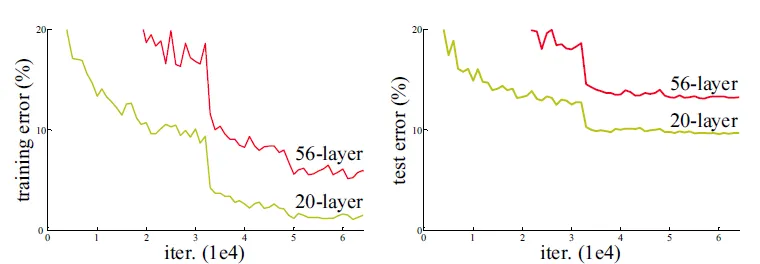

在之前的卷积网络结构的思想引导下，我们有一个基本的认识，使用多个小卷积核比使用一个大卷积核，在卷积核的视野相同的情况下，前者要好。

但是使用小卷积核就意味着一定要使用更深的网络结构，才能使网络有足够的表达能力，但是网络越深意味着一定准确率更高吗？

答案是否

网络越深容易引发梯度消失/爆炸的问题，而且根据实验表明，网络越深其准确率不一定越高，但是又需要让网络更深去获得更强的拟合能力——能不能保证更深层的网络的表现至少不比浅层的差？

于是就有了residual残差模块，其基本思想就是让浅层的网络的输出的结果直接与深层的结果叠加，那么至少深层的结果不会比浅层的结果差，而且事实证明这种结构的好处非常的多，在当年ResNet网络出现后，此年所有的图像任务比赛的冠军都是ResNet结构的。

resnet-block.svg

### ResNet

有了residual残差模块后，我们就可以设计超“深”的网络，ResNet突破1000层，这种网络有非常好的实践效果

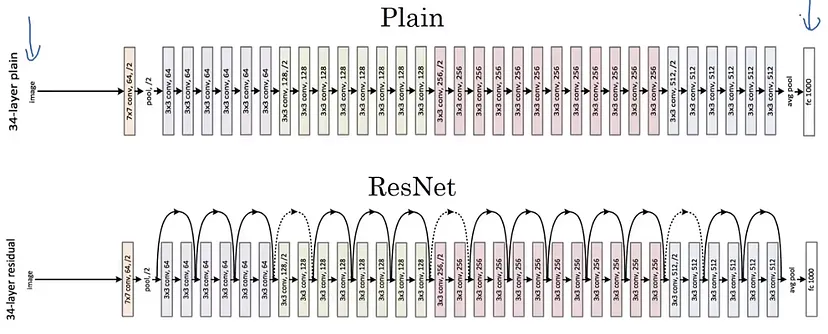

## model

In [ ]:
import torch.nn as nn
import torch


class BasicBlock(nn.Module): # 定义18，34层残差结果
    expansion = 1  # 主分支每一层所采用的卷积核个数是否发生变化
    """
    18,34层的残差结构主分支的卷积核个数没有发生变化，所以倍数为expansion = 1
    50，101，152层的每一层卷积核个数，第三组是前两组的4倍
    """

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        # -------------------------------------------------
        self.conv1 = nn.Conv2d(in_channel, out_channel,3, stride, 1, bias=False) # 禁用偏置项
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        # -------------------------------------------------
        self.conv2 = nn.Conv2d(out_channel, out_channel,3, 1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        # -------------------------------------------------
        self.downsample = downsample  # 定义下采样方法
        # -------------------------------------------------

    def forward(self, x):
        identity = x
        if self.downsample is not None:  # 实线结构：Not None 虚线结构：None
            identity = self.downsample(x)  # 虚线结构则跳过这一部分

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity # 加上捷径
        out = self.relu(out)

        return out


class Bottleneck(nn.Module): # 定义50，101，152层的残差结构

    expansion = 4
    def __init__(self, in_channel, out_channel, stride=1, downsample=None, groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups

        # -----------------------------------------
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel * self.expansion,
                               kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channel * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        # ------------------------------------------
        self.downsample = downsample  # 是否下采样
        # ------------------------------------------

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,block,blocks_num,num_classes=1000,include_top=True,groups=1,width_per_group=64):
        """
        :param block: 此参数为上面定义的block残差结构
        :param blocks_num: 使用的残差结构的数目，此参数为一个参数列表，例如50层的：（3， 4， 6， 3）
        :param num_classes:
        :param include_top: 作用：方便在此网络基础上搭建更复杂的网络
        :param groups:
        :param width_per_group:
        """
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.groups = groups
        self.width_per_group = width_per_group

        # 网络最初的输入卷积层
        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2, padding=3, bias=False) # 最初的输入为RGB图像，所以通道数为3
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # max pool 层

        # 这些layer层的构造在后面_make_layer函数
        self.layer1 = self._make_layer(block, 64, blocks_num[0])            # conv2_x对应的一系列残差结构
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2) # conv3_x对应的一系列残差结构
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2) # conv4_x对应的一系列残差结构
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2) # conv5_x对应的一系列残差结构

        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    # 构造layer层，将残差网络conv2~5_x归纳到四个layer结构中
    def _make_layer(self, block, channel, block_num, stride=1): # block_num使用该类残差网络层的个数
        downsample = None
        # 18 34 层则跳过这个for循环
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = [block(self.in_channel,channel,downsample=downsample,stride=stride,groups=self.groups,width_per_group=self.width_per_group)]
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num): # 根据 block_num 来定义个数
            layers.append(block(self.in_channel,channel,groups=self.groups,width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x


def resnet34(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet34-333f7ec4.pth
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet50-19c8e357.pth
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


def resnext50_32x4d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth
    groups = 32
    width_per_group = 4
    return ResNet(Bottleneck, [3, 4, 6, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


def resnext101_32x8d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth
    groups = 32
    width_per_group = 8
    return ResNet(Bottleneck, [3, 4, 23, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


## train

在网络的训练中使用了迁移学习

即在训练过程中，网络的卷积部分的参数并不参与参数更新，这部分的参数直接使用在更大数据集上预训练的权重，实际只训练网络的全连接层部分

In [ ]:
import torch
from torchvision import transforms, datasets
import json
import tqdm
import sys
import os

data_root = '/content/drive/MyDrive/Data'
model = 'resnet34'  # resnet34 resnet50,resnet101,resnext50_32x4d,resnext101_32x8d
mandate = 'hand'  # 'flower' 'hand'
model_weight_path = "/content/drive/MyDrive/path/resnet34-333f7ec4.pth"
save_path = model + '-' + mandate + '.pth'
init_weights = True
batch_size = 16
num_epoch = 3
learning_rate = 0.0001


def main():
    global net
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    '''数据预处理方法'''
    data_transform = \
        {  # 训练集
            "train": transforms.Compose([transforms.RandomResizedCrop(224),  # 随机裁剪出一个区域,然后resize到224x224大小
                                         transforms.RandomHorizontalFlip(),  # 随机水平翻转
                                         transforms.ToTensor(),  # 图像转换成tensor格式
                                         transforms.Normalize(  # 图像标准化,均值：(0.5,0.5,0.5),标准差：(0.5,0.5,0.5)
                                             (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
            # 测试集
            "val": transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        }

    '''读取数据集'''
    data = mandate + '_data'
    image_path = os.path.join(data_root, data)  # 'D:/data/hand_data' 'D:/data/flower_data'
    # 确认文件路径存在
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    print("working in {} by {}".format(data, model))

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)
    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                            transform=data_transform["val"])
    val_num = len(validate_dataset)
    print("using {} test_images for training, {} test_images for validation.".format(train_num, val_num))

    # 确定分类类别
    mandate_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in mandate_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    # 多进程 确定合适的worker数量
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    '''数据加载器'''
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)

    '''设置网络'''
    num_classes = 6 if mandate == 'hand' else 5
    if model == 'resnet34':
        net = resnet34()
    elif model == 'resnet50':
        net = resnet50()
    elif model == 'resnet101':
        net = resnet101()
    elif model == 'resnext50_32x4d':
        net = resnext50_32x4d()
    elif model == 'resnext101_32x8d':
        net = resnext101_32x8d()
    else:
        print("model name error")
        return

    # 加载预训练权重
    assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
    net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))

    # 根据分类的要求修改网络的全连接层
    in_channel = net.fc.in_features
    net.fc = torch.nn.Linear(in_channel, num_classes) # 重新赋值全连接层 num_classes个分类类别

    # 将网络发给device
    net.to(device)

    '''训练'''
    loss_function = torch.nn.CrossEntropyLoss()  # 定义损失函数

    # 只需要训练网络的部分层即可，
    # 前面的卷积层视为“特征提取”模块，可以使用预训练的权重，因此只需要训练全连接层（“分类功能”模块）
    params = [p for p in net.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=learning_rate)  # Adam优化器

    best_acc = 0.0  # 最佳准确率
    for epoch in range(num_epoch):
        running_loss = 0.0
        net.train()  # 将网络设置为训练模式，开启dropout
        train_bar = tqdm.tqdm(train_loader, file=sys.stdout)  # 训练进程进度条显示
        for step, data in enumerate(train_bar):
            images, labels = data

            optimizer.zero_grad()
            outputs = net(images.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, num_epoch, loss)

        '''计算在测试集的准确率'''
        net.eval()  # 在预测时关闭Dropout方法
        acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm.tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num  # 统计训练过程的平均损失
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / len(train_loader), val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')


if __name__ == "__main__":
    main()


using cuda:0 device.
working in hand_data by resnet34
using 4548 test_images for training, 501 test_images for validation.
Using 2 dataloader workers every process
100%|██████████| 32/32 [02:31<00:00,  4.75s/it]
[epoch 1] train_loss: 0.423  val_accuracy: 0.988
100%|██████████| 32/32 [00:01<00:00, 16.13it/s]
[epoch 2] train_loss: 0.236  val_accuracy: 0.988
100%|██████████| 32/32 [00:01<00:00, 16.32it/s]
[epoch 3] train_loss: 0.218  val_accuracy: 0.992
Finished Training


## 预测

class: A            prob: 7.08e-05
class: B            prob: 0.000133
class: C            prob: 1.23e-05
class: Five         prob: 4.44e-05
class: Point        prob: 0.0299
class: V            prob: 0.97


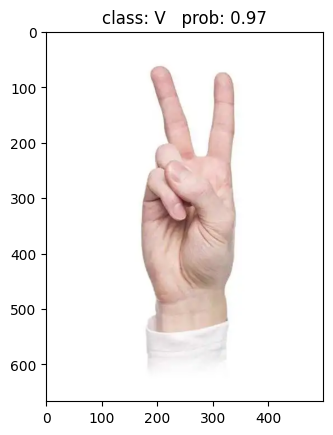

In [ ]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

img_path = "/content/drive/MyDrive/Data/hand_data/test/hand1.jpg"
weights_path = "/content/drive/MyDrive/path/resnet34-hand.pth"
num_classes = 6   # flower 5  hand 6


def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # load image
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)
    plt.imshow(img)
    img = data_transform(img)# [N, C, H, W]
    img = torch.unsqueeze(img, dim=0)# expand batch dimension

    # read class_indict
    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    with open(json_path, "r") as f:
        class_indict = json.load(f)

    # create model
    model = resnet34(num_classes=num_classes).to(device)

    # load model weights
    assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
    model.load_state_dict(torch.load(weights_path, map_location=device))

    model.eval()
    with torch.no_grad():
        # predict class
        output = torch.squeeze(model(img.to(device))).cpu()
        '''
        img.to(device) 将张量移动到指定device。
        model(img) 在device上运行模型。
        torch.squeeze 消除无用的单维度,主要是batch维度
        .cpu() 将张量移回CPU，进行后续的操作
        '''
        predict = torch.softmax(output, dim=0)      # 将分类结果转换成类别概率
        predict_cla = torch.argmax(predict).numpy()

    print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                                 predict[predict_cla].numpy())
    plt.title(print_res)
    for i in range(len(predict)):
        print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                                  predict[i].numpy()))
    plt.show()


if __name__ == '__main__':
    main()


# x-ray数据集

## model

In [4]:
import torch.nn as nn
import torch


class BasicBlock(nn.Module): # 定义18，34层残差结果
    expansion = 1  # 主分支每一层所采用的卷积核个数是否发生变化
    """
    18,34层的残差结构主分支的卷积核个数没有发生变化，所以倍数为expansion = 1
    50，101，152层的每一层卷积核个数，第三组是前两组的4倍
    """

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        # -------------------------------------------------
        self.conv1 = nn.Conv2d(in_channel, out_channel,3, stride, 1, bias=False) # 禁用偏置项
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        # -------------------------------------------------
        self.conv2 = nn.Conv2d(out_channel, out_channel,3, 1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        # -------------------------------------------------
        self.downsample = downsample  # 定义下采样方法
        # -------------------------------------------------

    def forward(self, x):
        identity = x
        if self.downsample is not None:  # 实线结构：Not None 虚线结构：None
            identity = self.downsample(x)  # 虚线结构则跳过这一部分

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity # 加上捷径
        out = self.relu(out)

        return out


class Bottleneck(nn.Module): # 定义50，101，152层的残差结构

    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups

        # -----------------------------------------
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel * self.expansion,
                               kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channel * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        # ------------------------------------------
        self.downsample = downsample  # 是否下采样
        # ------------------------------------------

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,block,blocks_num,num_classes=1000,include_top=True,groups=1,width_per_group=64):
        """
        :param block: 此参数为上面定义的block残差结构
        :param blocks_num: 使用的残差结构的数目，此参数为一个参数列表，例如50层的：（3， 4， 6， 3）
        :param num_classes:
        :param include_top: 作用：方便在此网络基础上搭建更复杂的网络
        :param groups:
        :param width_per_group:
        """
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.groups = groups
        self.width_per_group = width_per_group

        # 网络最初的输入卷积层
        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2, padding=3, bias=False) # 最初的输入为RGB图像，所以通道数为3
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # max pool 层

        # 这些layer层的构造在后面_make_layer函数
        self.layer1 = self._make_layer(block, 64, blocks_num[0])            # conv2_x对应的一系列残差结构
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2) # conv3_x对应的一系列残差结构
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2) # conv4_x对应的一系列残差结构
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2) # conv5_x对应的一系列残差结构

        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    # 构造layer层，将残差网络conv2~5_x归纳到四个layer结构中
    def _make_layer(self, block, channel, block_num, stride=1): # block_num使用该类残差网络层的个数
        downsample = None
        # 18 34 层则跳过这个for循环
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = [block(self.in_channel,channel,downsample=downsample,stride=stride,groups=self.groups,width_per_group=self.width_per_group)]
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num): # 根据 block_num 来定义个数
            layers.append(block(self.in_channel,channel,groups=self.groups,width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x


def resnet34(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet34-333f7ec4.pth
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet50-19c8e357.pth
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


def resnext50_32x4d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth
    groups = 32
    width_per_group = 4
    return ResNet(Bottleneck, [3, 4, 6, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


def resnext101_32x8d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth
    groups = 32
    width_per_group = 8
    return ResNet(Bottleneck, [3, 4, 23, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)




## train

In [5]:
import torch
from torchvision import transforms, datasets
import json
import tqdm
import sys
import os

data_root = '/content/drive/MyDrive/Data/chest_xray'
model = 'resnet50'  # resnet34 resnet50,resnet101,resnext50_32x4d,resnext101_32x8d
model_weight_path = "/content/drive/MyDrive/path/resnet50-19c8e357.pth"
init_weights = True
num_classes = 2
batch_size = 32
num_epoch = 10
learning_rate = 0.0001
save_path = model + '-b'+str(batch_size)+'-e'+str(num_epoch) + 'chest_xray' + '.pth'

test_acc = []
train_acc = []
test_loss = []
train_loss = []


def main():
    global net
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    '''数据预处理方法'''
    data_transform = \
        {  # 训练集
            "train": transforms.Compose([transforms.RandomResizedCrop(224),  # 随机裁剪出一个区域,然后resize到224x224大小
                transforms.RandomHorizontalFlip(),  # 随机水平翻转
                transforms.ToTensor(),  # 图像转换成tensor格式
                transforms.Normalize(  # 图像标准化,均值：(0.5,0.5,0.5),标准差：(0.5,0.5,0.5)
                                             (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
            # 测试集
            "test": transforms.Compose([transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        }

    '''读取数据集'''
    image_path = data_root
    # 确认文件路径存在
    assert os.path.exists(data_root), "{} path does not exist.".format(image_path)
    print("working in {} by {}".format('chest_xray', model))

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
              transform=data_transform["train"])
    train_num = len(train_dataset)
    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "test"),
              transform=data_transform["test"])
    val_num = len(validate_dataset)
    print("using {} test_images for training, {} test_images for validation.".format(train_num, val_num))

    # 确定分类类别
    mandate_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in mandate_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    # 多进程 确定合适的worker数量
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    '''数据加载器'''
    train_loader = torch.utils.data.DataLoader(train_dataset,
            batch_size=batch_size, shuffle=True,
            num_workers=nw)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
            batch_size=batch_size, shuffle=False,
            num_workers=nw)

    '''设置网络'''
    if model == 'resnet34':
        net = resnet34()
    elif model == 'resnet50':
        net = resnet50()
    elif model == 'resnet101':
        net = resnet101()
    elif model == 'resnext50_32x4d':
        net = resnext50_32x4d()
    elif model == 'resnext101_32x8d':
        net = resnext101_32x8d()
    else:
        print("model name error")
        return

    # 加载预训练权重
    assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
    net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))

    # 根据分类的要求修改网络的全连接层
    in_channel = net.fc.in_features
    net.fc = torch.nn.Linear(in_channel, num_classes) # 重新赋值全连接层 num_classes个分类类别

    # 将网络发给device
    net.to(device)

    '''训练'''
    loss_function = torch.nn.CrossEntropyLoss()  # 定义损失函数

    # 只需要训练网络的部分层即可，
    # 前面的卷积层视为“特征提取”模块，可以使用预训练的权重，因此只需要训练全连接层（“分类功能”模块）
    params = [p for p in net.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=learning_rate)  # Adam优化器

    best_acc = 0.0  # 最佳准确率
    num = 0
    for epoch in range(num_epoch):
        if num == 0:
            # -----------------------------------------------------------
            '''计算在测试集的准确率与loss值'''
            net.eval()  # 在预测时关闭Dropout方法
            acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
            vrunning_loss = 0.0
            val_bar = tqdm.tqdm(validate_loader, file=sys.stdout)
            with torch.no_grad():
                for val_data in val_bar:
                    val_images, val_labels = val_data
                    optimizer.zero_grad()
                    outputs = net(val_images.to(device))
                    loss = loss_function(outputs, val_labels.to(device))
                    vrunning_loss += loss
                    predict_y = torch.max(outputs, dim=1)[1]
                    acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
            val_accurate = acc / val_num
            test_acc.append(val_accurate)
            test_loss.append(vrunning_loss / len(validate_loader))
            # ----------------------------------------------------------
            # -----------------------------------------------------------
            '''计算在训练集的准确率与loss值'''
            net.eval()  # 在预测时关闭Dropout方法
            acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
            trunning_loss = 0.0
            with torch.no_grad():
                train_bar = tqdm.tqdm(train_loader, file=sys.stdout)
                for train_data in train_bar:
                    train_images, train_labels = train_data
                    outputs = net(train_images.to(device))
                    loss = loss_function(outputs, train_labels.to(device))
                    trunning_loss += loss
                    predict_y = torch.max(outputs, dim=1)[1]
                    acc += torch.eq(predict_y, train_labels.to(device)).sum().item()
            train_accurate = acc / train_num
            train_acc.append(train_accurate)
            train_loss.append(trunning_loss / len(train_loader))
            # -----------------------------------------------------------

        # -----------------------------------------------------------
        running_loss = 0.0
        net.train()  # 将网络设置为训练模式，开启dropout
        train_bar = tqdm.tqdm(train_loader, file=sys.stdout)  # 训练进程进度条显示
        for step, data in enumerate(train_bar):
            images, labels = data

            optimizer.zero_grad()
            outputs = net(images.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, num_epoch, loss)
        # -----------------------------------------------------------

        # -----------------------------------------------------------
        '''计算在测试集的准确率与loss值'''
        net.eval()  # 在预测时关闭Dropout方法
        acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
        vrunning_loss = 0.0
        val_bar = tqdm.tqdm(validate_loader, file=sys.stdout)
        with torch.no_grad():
            for val_data in val_bar:
                val_images, val_labels = val_data
                optimizer.zero_grad()
                outputs = net(val_images.to(device))
                loss = loss_function(outputs, val_labels.to(device))
                vrunning_loss += loss
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = acc / val_num
        test_acc.append(val_accurate)
        test_loss.append(vrunning_loss/len(validate_loader))
        num += 1
        # ----------------------------------------------------------
        #-----------------------------------------------------------
        '''计算在训练集的准确率与loss值'''
        net.eval()  # 在预测时关闭Dropout方法
        acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
        trunning_loss = 0.0
        with torch.no_grad():
            train_bar = tqdm.tqdm(train_loader, file=sys.stdout)
            for train_data in train_bar:
                train_images, train_labels = train_data
                outputs = net(train_images.to(device))
                loss = loss_function(outputs, train_labels.to(device))
                trunning_loss += loss
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, train_labels.to(device)).sum().item()
        train_accurate = acc / train_num
        train_acc.append(train_accurate)
        train_loss.append(trunning_loss / len(train_loader))
        # -----------------------------------------------------------

        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f test_accuracy: %.3f ' %
              (epoch + 1, running_loss / len(train_loader), train_accurate, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(),'/content/drive/MyDrive/path/'+save_path)

    print('Finished Training')

    print(test_acc)
    print(train_acc)
    print(test_loss)
    print(train_loss)


if __name__ == "__main__":
    main()


using cuda:0 device.
working in chest_xray by resnet50
using 5224 test_images for training, 624 test_images for validation.
Using 2 dataloader workers every process
100%|██████████| 164/164 [01:16<00:00,  2.15it/s]
[epoch 1] train_loss: 0.213  train_accuracy: 0.930 test_accuracy: 0.859 
100%|██████████| 164/164 [01:17<00:00,  2.12it/s]
[epoch 2] train_loss: 0.155  train_accuracy: 0.957 test_accuracy: 0.913 
100%|██████████| 164/164 [01:22<00:00,  1.99it/s]
[epoch 3] train_loss: 0.138  train_accuracy: 0.949 test_accuracy: 0.958 
100%|██████████| 164/164 [01:16<00:00,  2.14it/s]
[epoch 4] train_loss: 0.130  train_accuracy: 0.960 test_accuracy: 0.962 
100%|██████████| 164/164 [01:18<00:00,  2.08it/s]
[epoch 5] train_loss: 0.118  train_accuracy: 0.951 test_accuracy: 0.918 
100%|██████████| 164/164 [01:21<00:00,  2.00it/s]
[epoch 6] train_loss: 0.117  train_accuracy: 0.958 test_accuracy: 0.950 
100%|██████████| 164/164 [01:21<00:00,  2.01it/s]
[epoch 7] train_loss: 0.111  train_accuracy: 0.

## test